In [2]:
#from torchvision.models import resnet18
#pip install keras-cv --upgrade

In [1]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import *
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
import keras
import tensorflow as tf
from keras import models
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#from keras_cv.models.resnet_v1 import ResNet18
from tensorflow.keras.applications.resnet50 import ResNet50
import glob

#Load dataset

In [6]:
csv = glob.glob( '/content/drive/MyDrive/Colab Notebooks/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/**.csv')
images = glob.glob('/content/drive/MyDrive/Colab Notebooks/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/**.bmp')

In [7]:
print("There are totatl {} csv files in the given dataset".format(len(csv)))
print("There are total {} image files in the given dataset".format(len(images)))

There are totatl 1 csv files in the given dataset
There are total 330 image files in the given dataset


In [8]:
df = pd.read_csv(csv[0])
print('\n dataset information:\n')
df.info()
print('\n sum of Nan data:\n')
df.isna().sum()


 dataset information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   name                                   165 non-null    object
 1   patient ID                             165 non-null    int64 
 2    grade (GlaS)                          165 non-null    object
 3    grade (Sirinukunwattana et al. 2015)  165 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.3+ KB

 sum of Nan data:



name                                     0
patient ID                               0
 grade (GlaS)                            0
 grade (Sirinukunwattana et al. 2015)    0
dtype: int64

##show a random image and change it to what article wants

original image


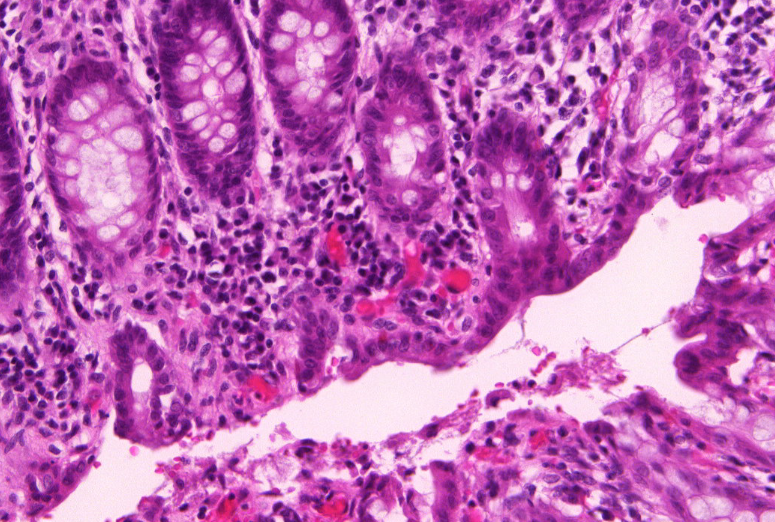

In [9]:
#plot a random image
j = np.random.randint(0,len(images))
img=Image.open(images[j])
print('original image')
Image.open(images[j])

grayscale image


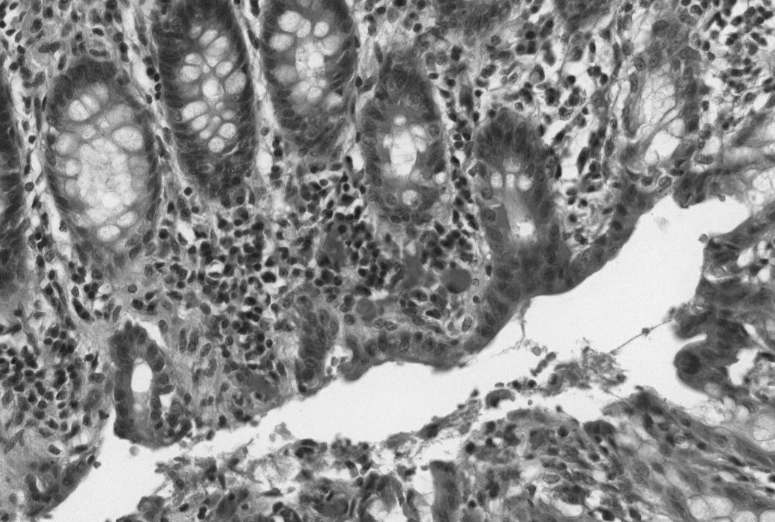

grayscale image after clahe


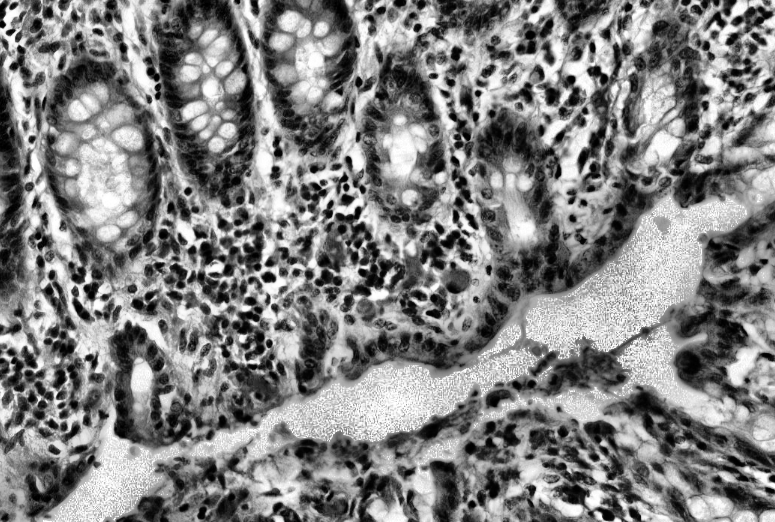

In [10]:
# The initial processing of the image
grayimg = np.asarray(cv2.cvtColor(np.array(img.convert('RGB')), cv2.COLOR_BGR2GRAY))
# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit = 20)
finalimg = np.asarray(clahe.apply(grayimg))
print('grayscale image')
cv2_imshow(grayimg)
print('grayscale image after clahe')
cv2_imshow(finalimg)

# preprocessing dataset
turn image to grayscale
& increase contrast by CLAHE

In [57]:
#delete anno.bmp images
imgs = []
for i in range (330):
  path=images[i].split("/",7)
  anno = path[7].split('_',2)
  if len(anno) < 3:
    imgs.append(images[i])

x = []
for i in range(165):
    temp = tf.keras.preprocessing.image.load_img(
        path = imgs[i])
    img = np.array(temp.convert('RGB'))
    img = cv2.resize(img,(224,224))
    gryimg = np.asarray(cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY))
    # The declaration of CLAHE
    # clipLimit -> Threshold for contrast limiting
    clahe = cv2.createCLAHE(clipLimit = 20)
    finalimg = np.asarray(clahe.apply(gryimg))
    finalimg = cv2.cvtColor(finalimg, cv2.COLOR_GRAY2BGR)#normalize and make 3d image
    x.append(finalimg)
x = np.array(x)

In [58]:
y = []
for i in range(165):
  path = imgs[i].split("/",7)
  name = path[7].split('.')
  for j in range(165):
    if df['name'][j] == name[0] :
      if df[' grade (GlaS)'][j] == ' benign':
        y.append(1)
      if df[' grade (GlaS)'][j] == ' malignant':
        y.append(0)
y = np.array(y)

In [126]:
from sklearn.model_selection import train_test_split
#y = to_categorical(y) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
# Checkout the Data
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

Training data shape :  (132, 224, 224, 3) (132,)
Testing data shape :  (33, 224, 224, 3) (33,)


#bulding th Resnet50 model

In [128]:
#========================== buliding the model =================================
input_shape_resnet = (224, 224, 3)
resenet_model = ResNet50(weights='imagenet',
                          input_shape=input_shape_resnet,
                          include_top=False)
#========================== unfreeze last 3 conv layers ========================
for layer in resenet_model.layers[0 : -11]:
    layer.trainable = False
resenet_model.summary()
#========================== adding layers ======================================
inp_layer = Input(shape = (224, 224, 3))
features = resenet_model(inp_layer)
flat = Flatten()(features)
N = keras.layers.BatchNormalization()(flat)
FC1 = Dense(224, activation = 'relu')(N)
N = keras.layers.BatchNormalization()(FC1)
drop = Dropout(0.25)(N)
FC3 = Dense(100, activation = 'relu')(drop)
output = Dense(1, activation = 'relu')(FC3)
model = Model(inputs = inp_layer, outputs = output)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_38[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           


#Train model with 80%train & 20%test data



In [129]:
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.00001), metrics=['accuracy'])
fitting = model.fit(X_train, y_train,
                    batch_size=8, epochs=250, validation_split=0.2) #it's 250 epoch 

Epoch 1/250
14/14 [==============================] - 5s 135ms/step - loss: 5.3014 - accuracy: 0.5333 - val_loss: 4.9375 - val_accuracy: 0.5556
Epoch 2/250
14/14 [==============================] - 1s 48ms/step - loss: 4.2692 - accuracy: 0.5905 - val_loss: 4.3980 - val_accuracy: 0.5926
Epoch 3/250
14/14 [==============================] - 1s 48ms/step - loss: 4.4253 - accuracy: 0.6095 - val_loss: 3.3702 - val_accuracy: 0.5926
Epoch 4/250
14/14 [==============================] - 1s 48ms/step - loss: 3.7008 - accuracy: 0.6095 - val_loss: 3.7037 - val_accuracy: 0.5926
Epoch 5/250
14/14 [==============================] - 1s 51ms/step - loss: 2.5175 - accuracy: 0.7048 - val_loss: 3.1858 - val_accuracy: 0.6296
Epoch 6/250
14/14 [==============================] - 1s 48ms/step - loss: 3.1909 - accuracy: 0.6667 - val_loss: 3.6214 - val_accuracy: 0.6667
Epoch 7/250
14/14 [==============================] - 1s 48ms/step - loss: 2.6501 - accuracy: 0.6571 - val_loss: 3.5998 - val_accuracy: 0.7037
Epoch


 20% test & 80% train



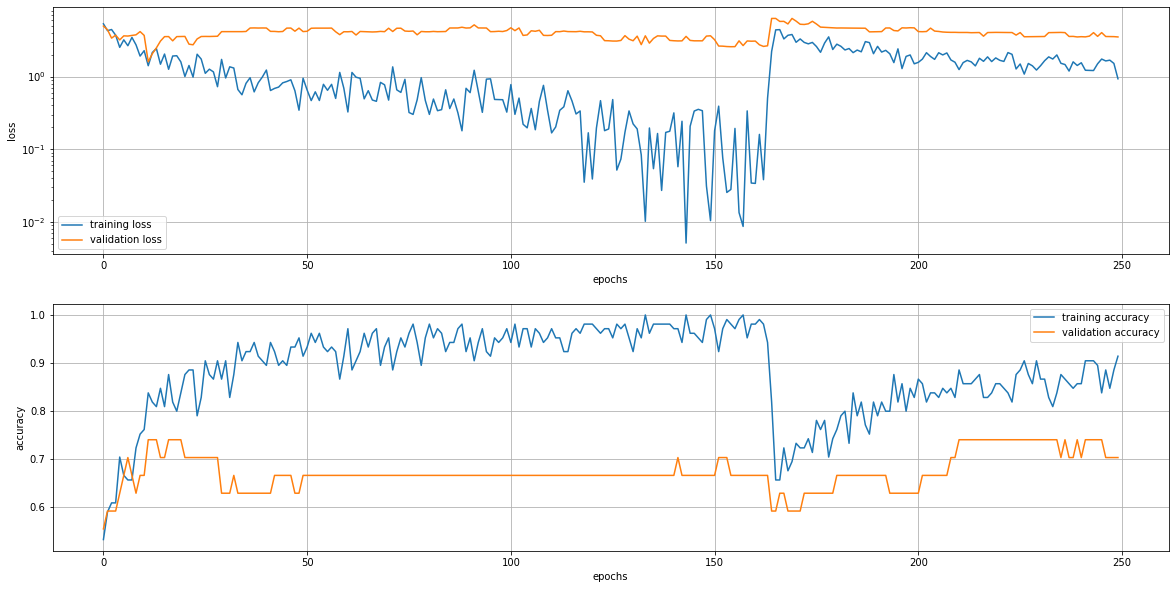

In [130]:
train_loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
train_acc = fitting.history['accuracy']
val_acc = fitting.history['val_accuracy']
print('\n 20% test & 80% train\n')
plt.subplots(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [121]:
#y_pred = model.predict(X_test)
#print('\ntesteing by 20% test & 80% train')
#print('\naccuracy = ',accuracy_score(np.argmax(y_test,axis=-1), np.argmax(y_pred,axis=-1)))
#print('precision = ',precision_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),average='macro'))
#print('f1 = ',f1_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),average='macro'),'\n')

2/2 [==============================] - 1s 112ms/step

 20% test & 80% train

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        18
           1       1.00      0.67      0.80        15

    accuracy                           0.85        33
   macro avg       0.89      0.83      0.84        33
weighted avg       0.88      0.85      0.84        33



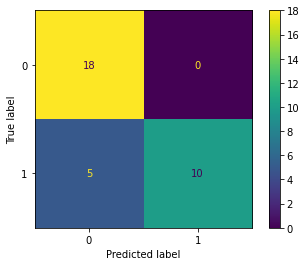

In [131]:
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh]  = 0
cls_report = classification_report(y_test, y_pred)

print('\n 20% test & 80% train\n')
print(cls_report)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))


#Train model with 75%train & 25%test data



In [103]:
del model
#y = to_categorical(y) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
# Checkout the Data
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
#========================== buliding the model =================================
input_shape_resnet = (224, 224, 3)
resenet_model = ResNet50(weights='imagenet',
                          input_shape=input_shape_resnet,
                          include_top=False)
#========================== unfreeze last 3 conv layers ========================
for layer in resenet_model.layers[0 : -11]:
    layer.trainable = False
#========================== adding layers ======================================
inp_layer = Input(shape = (224, 224, 3))
features = resenet_model(inp_layer)
flat = Flatten()(features)
N = keras.layers.BatchNormalization()(flat)
FC1 = Dense(224, activation = 'relu')(N)
N = keras.layers.BatchNormalization()(FC1)
drop = Dropout(0.25)(N)
FC3 = Dense(100, activation = 'relu')(drop)
output = Dense(1, activation = 'relu')(FC3)
model = Model(inputs = inp_layer, outputs = output)

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.00001), metrics=['accuracy'])
fitting = model.fit(X_train, y_train,
                    batch_size=8, epochs=150, validation_split=0.2)

Training data shape :  (123, 224, 224, 3) (123,)
Testing data shape :  (42, 224, 224, 3) (42,)
Epoch 1/150
13/13 [==============================] - 5s 135ms/step - loss: 5.9710 - accuracy: 0.5306 - val_loss: 6.7876 - val_accuracy: 0.5600
Epoch 2/150
13/13 [==============================] - 1s 48ms/step - loss: 5.9895 - accuracy: 0.5306 - val_loss: 6.7870 - val_accuracy: 0.5600
Epoch 3/150
13/13 [==============================] - 1s 48ms/step - loss: 5.8829 - accuracy: 0.5102 - val_loss: 6.7870 - val_accuracy: 0.5600
Epoch 4/150
13/13 [==============================] - 1s 49ms/step - loss: 6.0843 - accuracy: 0.5612 - val_loss: 6.7870 - val_accuracy: 0.5600
Epoch 5/150
13/13 [==============================] - 1s 49ms/step - loss: 5.1077 - accuracy: 0.5612 - val_loss: 6.2855 - val_accuracy: 0.5600
Epoch 6/150
13/13 [==============================] - 1s 51ms/step - loss: 5.1382 - accuracy: 0.5714 - val_loss: 3.9881 - val_accuracy: 0.6400
Epoch 7/150
13/13 [==============================] -


 25% test & 75% train



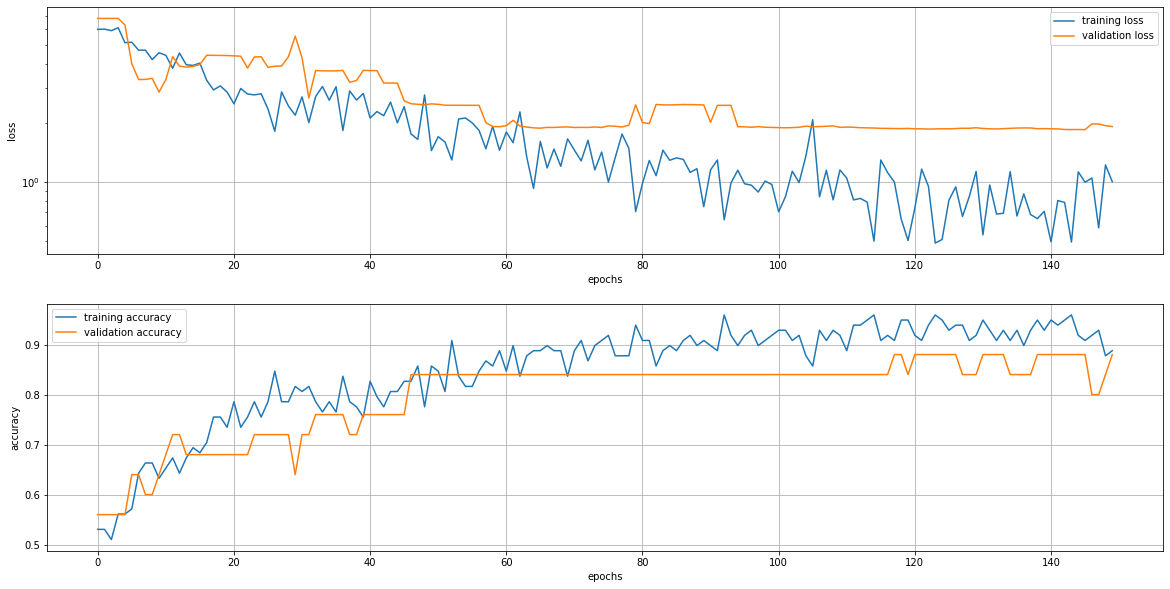

In [104]:
train_loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
train_acc = fitting.history['accuracy']
val_acc = fitting.history['val_accuracy']
print('\n 25% test & 75% train\n')
plt.subplots(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

2/2 [==============================] - 1s 615ms/step

 25% test & 75% train

              precision    recall  f1-score   support

           0       0.73      0.96      0.83        23
           1       0.92      0.58      0.71        19

    accuracy                           0.79        42
   macro avg       0.82      0.77      0.77        42
weighted avg       0.82      0.79      0.78        42



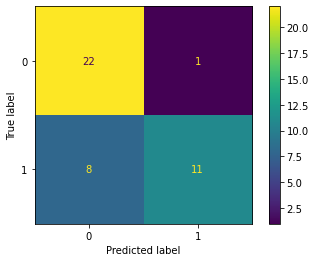

In [105]:
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh]  = 0
cls_report = classification_report(y_test, y_pred)

print('\n 25% test & 75% train\n')
print(cls_report)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))


#Train model with 60%train & 40%test data



In [106]:
del model
#y = to_categorical(y) 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=10)
# Checkout the Data
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)
#========================== buliding the model =================================
input_shape_resnet = (224, 224, 3)
resenet_model = ResNet50(weights='imagenet',
                          input_shape=input_shape_resnet,
                          include_top=False)
#========================== unfreeze last 3 conv layers ========================
for layer in resenet_model.layers[0 : -11]:
    layer.trainable = False
#========================== adding layers ======================================
inp_layer = Input(shape = (224, 224, 3))
features = resenet_model(inp_layer)
flat = Flatten()(features)
N = keras.layers.BatchNormalization()(flat)
FC1 = Dense(224, activation = 'relu')(N)
N = keras.layers.BatchNormalization()(FC1)
drop = Dropout(0.25)(N)
FC3 = Dense(100, activation = 'relu')(drop)
output = Dense(1, activation = 'relu')(FC3)
model = Model(inputs = inp_layer, outputs = output)

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.00001), metrics=['accuracy'])
fitting = model.fit(X_train, y_train,
                    batch_size=8, epochs=150, validation_split=0.2)

Training data shape :  (99, 224, 224, 3) (99,)
Testing data shape :  (66, 224, 224, 3) (66,)
Epoch 1/150
10/10 [==============================] - 6s 271ms/step - loss: 6.1617 - accuracy: 0.5570 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 2/150
10/10 [==============================] - 0s 49ms/step - loss: 6.3473 - accuracy: 0.5190 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 3/150
10/10 [==============================] - 0s 49ms/step - loss: 6.1787 - accuracy: 0.5316 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 4/150
10/10 [==============================] - 0s 49ms/step - loss: 6.0222 - accuracy: 0.5443 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 5/150
10/10 [==============================] - 0s 49ms/step - loss: 6.0014 - accuracy: 0.5570 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 6/150
10/10 [==============================] - 0s 49ms/step - loss: 5.9455 - accuracy: 0.5696 - val_loss: 6.1700 - val_accuracy: 0.6000
Epoch 7/150
10/10 [==============================] - 0


 40% test & 60% train



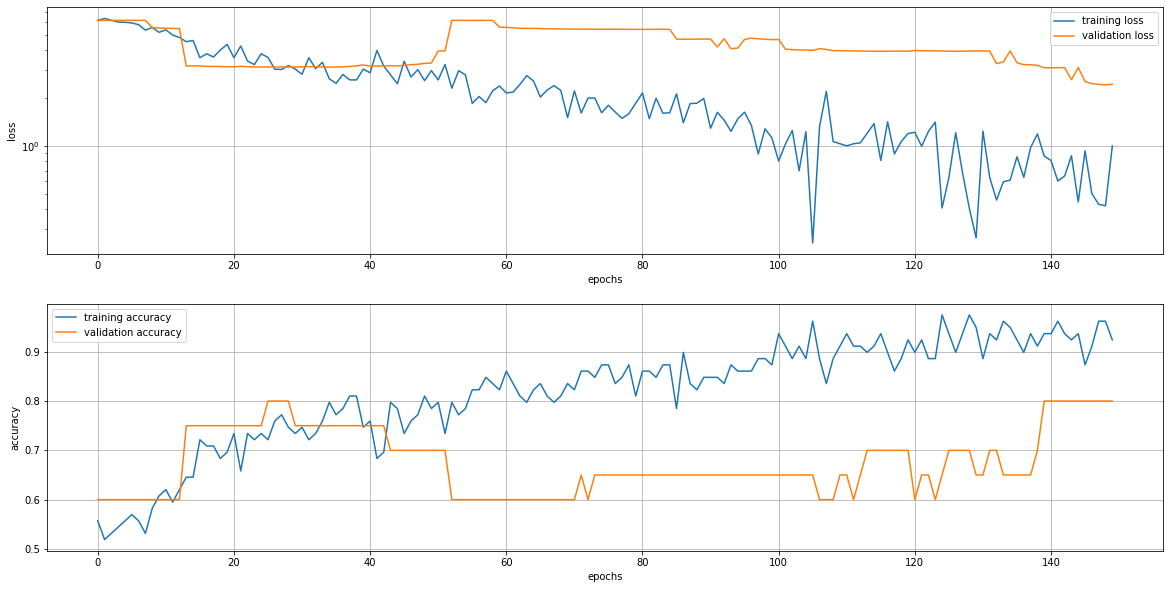

In [107]:
train_loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
train_acc = fitting.history['accuracy']
val_acc = fitting.history['val_accuracy']
print('\n 40% test & 60% train\n')
plt.subplots(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

3/3 [==============================] - 1s 106ms/step

 40% test & 60% train

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        37
           1       1.00      0.52      0.68        29

    accuracy                           0.79        66
   macro avg       0.86      0.76      0.76        66
weighted avg       0.85      0.79      0.77        66



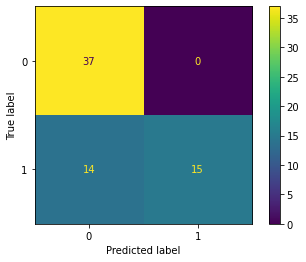

In [108]:
y_pred = model.predict(X_test)
thresh = 0.5
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh]  = 0
cls_report = classification_report(y_test, y_pred)

print('\n 40% test & 60% train\n')
print(cls_report)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))